In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import sys
sys.path.append('/home/fvadell/ml-tests/labs-ml-group/modules')
import custom_callbacks as cc
import some_functions

In [6]:
#style.use('seaborn-poster') #sets the size of the charts
plt.style.use('seaborn-darkgrid')

In [7]:
seed = 1

## Funciones

In [8]:
def recommend_for_user(learner, avisos, idusuario):
    
    arr = avisos
    user_pos = some_functions.id_to_position(x=idusuario, learner = learner, cat = 'idusuario')

    arr['user_pos'] = [user_pos for x in arr['idaviso']]
    arr['idusuario'] = [idusuario for x in arr['idaviso']]
    arr = arr.filter(['user_pos', 'pos', 'idaviso', 'idusuario'])
    
    arr = pd.merge(arr, hits_with_falses.filter(['idaviso', 'barrio']),how = 'inner' , on = 'idaviso')
    
    arr = arr.drop_duplicates('idaviso')

    arr['barrio_pos'] = [some_functions.id_to_position(x=x, learner=learn_hits, cat='barrio') for x in arr['barrio']]

    arr = arr.filter(['user_pos', 'pos', 'barrio_pos', 'idaviso', 'idusuario'])

    arr = pd.merge(arr, hits_with_falses.drop('idusuario', axis = 1), on = 'idaviso', how = 'inner')
    
    # Normalizamos las variables metros_cuadrados y precio
    arr['metros_n']=(arr['metros_cuadrados']-arr['metros_cuadrados'].mean())/arr['metros_cuadrados'].std()
    arr['precio_n']=(arr['precio']-arr['precio'].mean())/arr['precio'].std()

    arr = arr.filter(['user_pos', 'pos', 'barrio_pos', 'precio_n', 'metros_n', 'idaviso', 'idusuario'])
    arr = arr.drop_duplicates('idaviso')

    cat_variables = torch.LongTensor(arr.iloc[:,:3].values) # Las variables categoricas por un lado
    cont_variables = torch.FloatTensor(arr.iloc[:,-4:-2].values) # Y las continuas por el otro
    preds = learn_hits.model(cat_variables,cont_variables)

    preds = F.softmax(preds)
    preds.detach().numpy()

    arr['pred'] = preds.argmax(axis = 1).numpy()
    arr['trust'] = preds.max(axis = 1)[0].detach().numpy()
    
    recs = pd.merge(arr.filter(['idaviso', 'idusuario', 'pred', 'trust']), hits_with_falses.drop('idusuario', axis = 1), how='inner', on=['idaviso'])
    recs = recs.drop_duplicates('idaviso')

    recs = recs.sort_values(by = ['pred', 'trust'], ascending = [False, False])
    
    return recs

## Datos

In [9]:
path = Path('/home/fvadell/ml-tests/labs-ml-group/maestria-2019')
path.ls()

[PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/users_features.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/users_hitaviso.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/contactos_train.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/ratings_with_falses.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/licencia.txt'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/items_features.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/ratings_with_falses_filtered.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/hits_with_falses_filtered.csv'),
 PosixPath('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/contactos_test.csv')]

Cargo el csv "hits_with_falses" que es el dataset que armamos en la notebook "data_filtering".

In [10]:
hits_with_falses = pd.read_csv('/home/fvadell/ml-tests/labs-ml-group/maestria-2019/hits_with_falses_filtered.csv')

In [11]:
print(len(hits_with_falses))
hits_with_falses.head()

846631


,portal,date,idaviso,idusuario,fecha,fecha_alta,precio,moneda,tipo_de_propiedad,tipo_de_operacion,...,garages,banos,metros_cuadrados,metros_totales,antiguedad,barrio,fav_barrio,score,hits_user,hits_aviso
0,NaN,NaN,00029b801620e84d3e705c063d93af53fda113c8,081b656a0aafa4e9b930973501af3a1155f7a597,NaN,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,25,NaN
1,NaN,NaN,00029b801620e84d3e705c063d93af53fda113c8,09953a33cd36fbd5ea170d764e01fd81b8fed77f,NaN,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,13,NaN
2,NaN,NaN,00029b801620e84d3e705c063d93af53fda113c8,09f9cd52a44dd6445c4462de46318960974c3f2d,NaN,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,58,NaN
3,NaN,NaN,00029b801620e84d3e705c063d93af53fda113c8,16ebda3418bc336279b6c9a1ab9acda62d6a1e50,NaN,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,NaN,0,21,NaN
4,ZPAR,2018-10-15,00029b801620e84d3e705c063d93af53fda113c8,1c62b9df4a960d1f30ea49ca20227137f17c423e,2018-10-14 21:37:08,2018-10-05 17:19:42,180000.0,USD,Casa,Venta,...,0.0,1.0,87.0,280.0,50.0,San Isidro,Vicente López,1,40,10.0


#### Train set para hits_with_falses

In [12]:
np.random.seed(seed)
test_pct = 0.1
test_idx2 = np.random.choice(range(0, len(hits_with_falses)), round(test_pct*len(hits_with_falses)), replace=False)
train_idx2= list(set(hits_with_falses.index).difference(test_idx2))
print(len(test_idx2))

84663


## Tabular + features Hits

### Definición del modelo

In [13]:
hits_with_falses.columns

Index(['portal', 'date', 'idaviso', 'idusuario', 'fecha', 'fecha_alta',
       'precio', 'moneda', 'tipo_de_propiedad', 'tipo_de_operacion',
       'habitaciones', 'ambientes', 'garages', 'banos', 'metros_cuadrados',
       'metros_totales', 'antiguedad', 'barrio', 'fav_barrio', 'score',
       'hits_user', 'hits_aviso'],
      dtype='object')

In [14]:
df = hits_with_falses
dep_var = 'score'
cat_names = ['idusuario', 'idaviso', 'barrio']
cont_names = ['precio', 'metros_cuadrados']
cont_names = cont_names
procs = [FillMissing, Categorify, Normalize]

In [15]:
df['score'] = df['score'].astype(str)

In [16]:
data = (TabularList.from_df(df, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=test_idx2)
                           .label_from_df(cols=dep_var)
                           .databunch(bs = 2**10))

In [17]:
emb_szs_str = {
  "idusuario": 200,
  "idaviso": 100,
}

layers = [300, 150, 150, 100]
layers = [200, 50]

In [18]:
learn_hits = tabular_learner(data, 
                            layers=layers, 
                            #emb_szs=emb_szs_str,
                            metrics=[accuracy])

La siguiente línea es opcional si se quiere cargar los pesos pre entrenados.

In [19]:
#learn_hits.load("learn_hits")

Learner(data=TabularDataBunch;

Train: LabelList (761968 items)
x: TabularList
idusuario 081b656a0aafa4e9b930973501af3a1155f7a597; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; ,idusuario 09953a33cd36fbd5ea170d764e01fd81b8fed77f; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; ,idusuario 09f9cd52a44dd6445c4462de46318960974c3f2d; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; ,idusuario 16ebda3418bc336279b6c9a1ab9acda62d6a1e50; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; ,idusuario 1c62b9df4a960d1f30ea49ca20227137f17c423e; idaviso 00029b801620e84d3e705c063d93af53fda113c8; barrio San Isidro; precio -0.1127; metros_cuadrados -0.0073; 
y: CategoryList
0,0,0,0,1
Path: .;

Valid: LabelList (84663 items)
x: TabularList
idusuario f3779ff2a

### Entrenamiento del modelo

In [ ]:
early_stopping = cc.EarlyStoppingFede(learn = learn_hits, patience = 2)

In [ ]:
testCb = cc.TestCallback(learn = learn_hits)

In [ ]:
activation_stats_cb = callbacks.ActivationStats(learn_hits, [learn_hits.model.layers[0], learn_hits.model.layers[3], learn_hits.model.layers[6]])

In [ ]:
learn_hits.model

In [ ]:
learn_hits.loss_func

In [ ]:
learn_hits.lr_find()
learn_hits.recorder.plot(suggestion = True)

In [ ]:
learn_hits.fit_one_cycle(20, 1.0E-03, callbacks = [early_stopping, testCb, activation_stats_cb])

In [ ]:
learn_hits.recorder.plot_losses()
learn_hits.recorder.plot_metrics()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(learn_hits.activation_stats.stats[0][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_hits.activation_stats.stats[0][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_hits.activation_stats.stats[0][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_feat2.activation_stats.stats[0][3].numpy(), alpha = .8, label = '4')
#plt.plot(learn_feat2.activation_stats.stats[0][4].numpy(), alpha = .8, label = '5', color = 'k')

plt.grid()
plt.legend()
plt.title("Media de las capas lineas por cada batch pasado")
plt.grid()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(learn_hits.activation_stats.stats[1][0].numpy(), alpha = .8, label = '1')
plt.plot(learn_hits.activation_stats.stats[1][1].numpy(), alpha = .8, label = '2')
plt.plot(learn_hits.activation_stats.stats[1][2].numpy(), alpha = .8, label = '3')
#plt.plot(learn_feat2.activation_stats.stats[1][3].numpy(), alpha = .8, label = '4')
#plt.plot(learn_feat2.activation_stats.stats[1][4].numpy(), alpha = .8, label = '5', color = 'k')


plt.legend()
plt.title("Std de las capas lineas por cada batch pasado")
plt.show()

In [ ]:
#learn_hits.save("learn_hits", return_path=True)

### User Prediction Hits

#### Casos interesantes:

eada2f69b4a2acd4bee00393f142af80e517b0fc

1a486a1d35587d8fe39476e7b7d9d15f98c5f8e6

2eb39e52f7d42a7749dbfafd99bf609ca9f64ad1

77c7e00864c88b4c3df246c8005ea6d648e5b7d0

b1e619cffe281f510c6e945b25efc0d08f5211a4

Busco todos los avisos que hay en el train set con su respectiva posicion en la matriz de embeddings. Esto hay que cargarlo una sola vez.

In [20]:
avisos = pd.DataFrame()
avisos['idaviso'] = pd.Series(hits_with_falses.iloc[train_idx2, :]['idaviso']).unique()
avisos['pos'] = [some_functions.id_to_position(x=x, learner=learn_hits, cat='idaviso') for x in avisos['idaviso']]

Tomamos un usuario al azar

In [29]:
u = round(np.random.uniform(0, len(hits_with_falses['idusuario'].unique())))
idusuario = hits_with_falses['idusuario'][u]
hits_with_falses[hits_with_falses['idusuario']==idusuario].head().filter(cat_names+cont_names+['fav_barrio'])

,idusuario,idaviso,barrio,precio,metros_cuadrados,fav_barrio
8130,b7ba7916218d9aa0f75799804cba57662b6261d1,027c5fbe5ef07cdd2b9fda339342fbc6ce57797f,Las Cañitas,209900.0,70.0,Palermo
34261,b7ba7916218d9aa0f75799804cba57662b6261d1,0a967ddd5f07a1c9354ec856237626f157469e1d,San Isidro,179000.0,134.0,NaN
47645,b7ba7916218d9aa0f75799804cba57662b6261d1,0e72ae9368616f30bcc80a8ce112d64af5a0811f,Tigre,59000.0,60.0,NaN
72036,b7ba7916218d9aa0f75799804cba57662b6261d1,159355db540fbccc0d2fcbb639c7f9c33df11162,Palermo,180000.0,49.0,Palermo
77580,b7ba7916218d9aa0f75799804cba57662b6261d1,1756d64f43c828e8e8196077d2f386f2928c5bc2,Palermo,150000.0,42.0,Palermo


Armo la matriz "inspect" para ver los avisos a los que el usuario realmente le hizo lead

In [30]:
#idusuario = 'b1e619cffe281f510c6e945b25efc0d08f5211a4'

In [31]:
recs = recommend_for_user(learner = learn_hits, avisos = avisos, idusuario = idusuario)

In [32]:
inspect = hits_with_falses[(hits_with_falses['idusuario']==idusuario)]

In [33]:
inspect = inspect[inspect['score']=='1']

Nos quedamos con las recomendaciones 'nuevas', es decir que no están dentro de la tabla 'inspect'

In [34]:
_ = pd.merge(recs, inspect.filter(['idaviso']), on = 'idaviso', how = 'outer', indicator = True)
new_recs = _[_['_merge']=='left_only']
#a = a[a['_merge']=='left_only']

Y vemos sus preferencias de barrio comparado a lo que nosotros sugerimos

In [35]:
idusuario

'b7ba7916218d9aa0f75799804cba57662b6261d1'

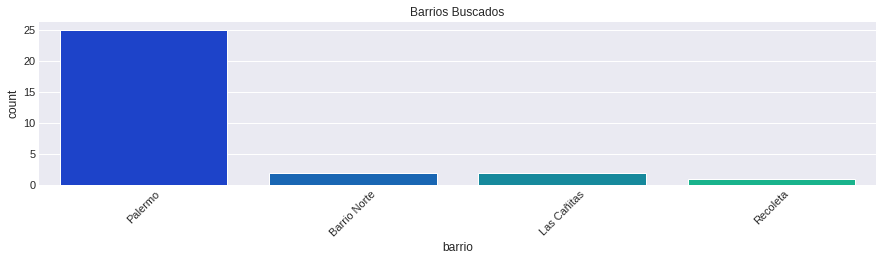

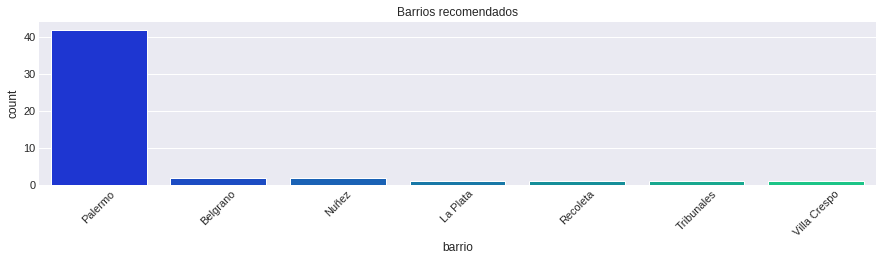

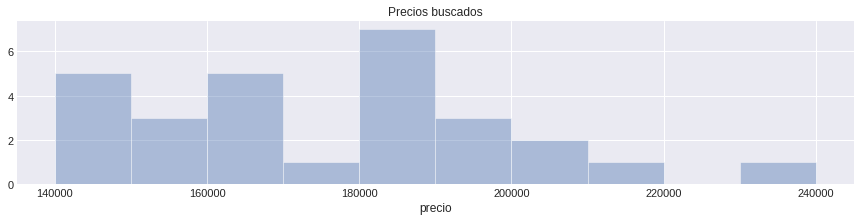

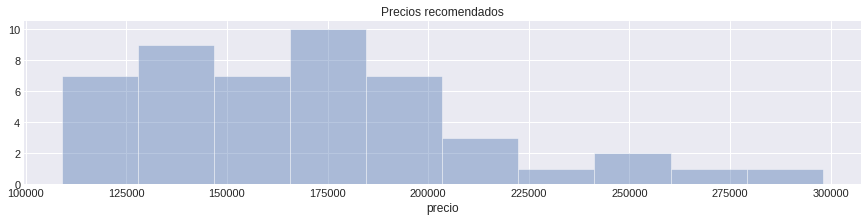

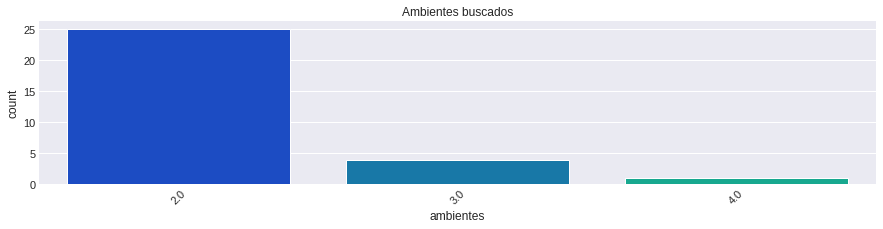

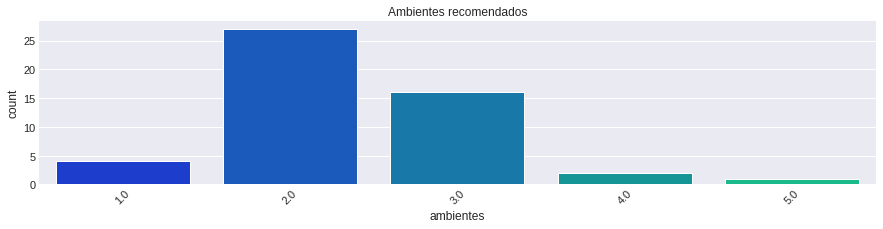

In [36]:
some_functions.plot_cat_dist(inspect, cat = 'barrio', title = 'Barrios Buscados', palette = ('winter'))
some_functions.plot_cat_dist(new_recs.head(50), cat = 'barrio', title = 'Barrios recomendados', palette = ('winter'))

some_functions.plot_cont_dist(inspect, var = 'precio', title = 'Precios buscados', bins = 10)
some_functions.plot_cont_dist(new_recs.head(50), var = 'precio', title = 'Precios recomendados', bins = 10)

some_functions.plot_cat_dist(inspect, cat = 'ambientes', title = 'Ambientes buscados', palette = ('winter'))
some_functions.plot_cat_dist(new_recs.head(50), cat = 'ambientes', title = 'Ambientes recomendados', palette = ('winter'))

### Visualization

In [37]:
from sklearn.manifold import TSNE

#### Barrios

In [38]:
embs = learn_hits.model.embeds[2].weight.detach().numpy()

In [39]:
def reduce_dim(weights, components = 3):
    """Reduce dimensions of embeddings"""
    
    return TSNE(components, metric = 'cosine', random_state = 4).fit_transform(weights)

In [40]:
embs_red = reduce_dim(embs, components = 2)

In [41]:
print(len(embs_red))
embs_red

207


array([[-8.283997,  5.664215],
       [-6.642375,  9.407526],
       [-3.209402, 12.551232],
       [ 0.630704, -2.078783],
       ...,
       [ 7.953978,  1.696758],
       [ 5.382688, -0.71882 ],
       [-1.753597, 11.857413],
       [ 3.042672, -2.132371]], dtype=float32)

In [42]:
some_functions.id_to_position(x='Saavedra', learner = learn_hits, cat = 'barrio')

146

In [43]:
len(learn_hits.data.dataset.x.classes['barrio'])

207

In [44]:
embs_red_df = pd.DataFrame(embs_red)
embs_red_df.columns = ['tsne1', 'tsne2']

In [45]:
embs_red_df['barrio'] = list(learn_hits.data.dataset.x.classes['barrio'])

In [46]:
embs_red_df.filter(['barrio', 'tsne1', 'tsne2'])
embs_red_df.head()

,tsne1,tsne2,barrio
0,-8.283997,5.664215,#na#
1,-6.642375,9.407526,Abasto
2,-3.209402,12.551232,Agronomía
3,0.630704,-2.078783,Agua de Oro
4,-7.454970,-3.431351,Aguas Verdes


In [47]:
aux = pd.DataFrame(hits_with_falses['barrio'].value_counts()).reset_index(drop = False)
aux['count'] = aux['barrio']
aux['barrio'] = aux['index']
aux = aux.drop('index', axis = 1)
embs_red_df = pd.merge(embs_red_df, aux)
embs_red_df.head()

,tsne1,tsne2,barrio,count
0,-6.642375,9.407526,Abasto,1008
1,-3.209402,12.551232,Agronomía,1360
2,0.630704,-2.078783,Agua de Oro,133
3,-7.454970,-3.431351,Aguas Verdes,87
4,-5.804923,9.246231,Almagro,20935


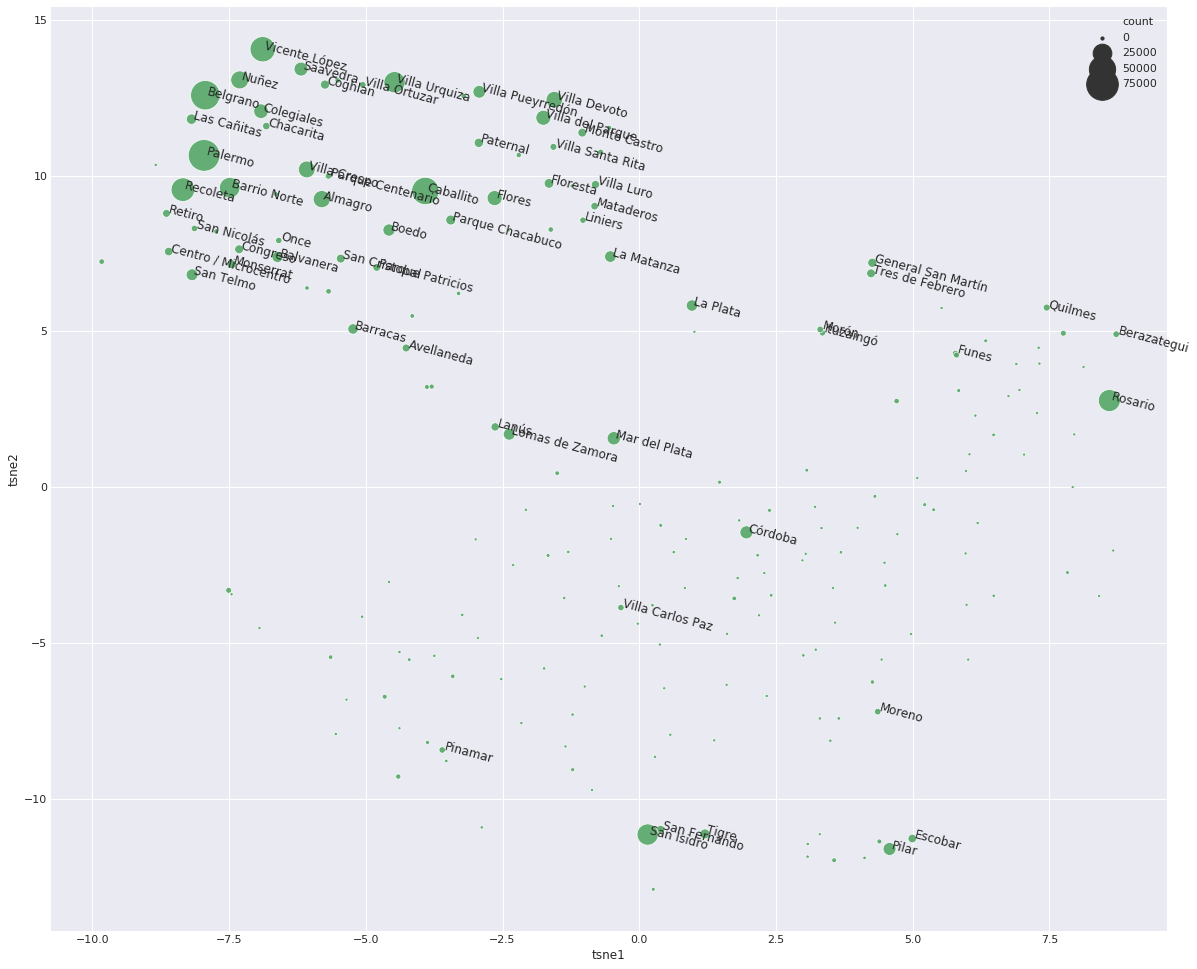

In [68]:
def label_point(x, y, val, ax, rot = 0):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']), rotation = rot)

movie = 'Die Hard'
data = embs_red_df
#data_movie = data[data['title'].str.contains(movie)]
barrio = 'Belgrano'

plt.figure(figsize=(20,17))
sns.set_style("darkgrid")
ax =sns.scatterplot(x="tsne1", y="tsne2",
              data=data, alpha = 0.9, 
                    size = 'count', 
                    sizes = (10, 1000),
                    legend = 'brief', 
                    color = 'g')
#ax1 =sns.scatterplot(x="tsne 1", y="tsne 2",
#                  data=data[data[genre]==1], alpha = 0.5,
#                  palette=('colorblind'), size = "reviews", sizes = (1, 500), legend = False)
#ax2 =sns.scatterplot(x="tsne1", y="tsne2",
#                  data=data[data['barrio']==barrio], alpha = 1,
#                  color = 'k', marker ='X', s = 500, legend = False)

top = embs_red_df[embs_red_df['count']>2000]
label_point(top['tsne1'], top['tsne2'], top['barrio'], ax, rot = -15)  

#plt.title("Embeddings for movies using T-SNE with highlighted genre: "+ genre);